<img src="https://github.com/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/img/nb_logo.png?raw=1" width="600">

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AI-HPC-Research-Team/AI-Basics/blob/main/06%20Transformer/ProtGPT2.ipynb)  

# ProtGPT2

ProtGPT2 ([Ferruz et al 2022](https://www.nature.com/articles/s41467-022-32007-7)) is a language model trained on the protein space that generates de novo protein sequences following the principles of natural ones. The generated proteins display natural amino acid propensities, distantly related to natural ones, as well as unexplored regions of protein space. AlphaFold prediction of ProtGPT2-sequences yields well-folded non-idealized structures with embodiments and large loops and reveals topologies not captured in current structure databases. ProtGPT2 generates sequences in a matter of seconds and is freely available through [Hugging Face](https://huggingface.co/nferruz/ProtGPT2).

![image.png](https://github.com/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/img/protgpt2.png?raw=1)


In [ ]:
# uncomment the below for colab

!pip install "transformers[torch]" biopython pymsaviz py3Dmol #> /dev/null
!apt-get install muscle #&> /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  muscle
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 244 kB of archives.
After this operation, 709 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 muscle amd64 1:3.8.1551-2build1 [244 kB]
Fetched 244 kB in 0s (2,533 kB/s)
Selecting previously unselected package muscle.
(Reading database ... 121229 files and directories currently installed.)
Preparing to unpack .../muscle_1%3a3.8.1551-2build1_amd64.deb ...
Unpacking muscle (1:3.8.1551-2build1) ...
Setting up muscle (1:3.8.1551-2build1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
#Set up working directories and download files/checkpoints
!mkdir protT5 # directory for storing checkpoints, results etc
!mkdir protT5/output # directory for storing sequences

mkdir: cannot create directory ‘protT5’: File exists
mkdir: cannot create directory ‘protT5/output’: File exists


In [ ]:
# import dependencies
import transformers
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio import AlignIO
import requests
import py3Dmol
from pymsaviz import MsaViz
import os
import time
import re
import subprocess

# path variables
output_path = './protT5/output'

#initialise language model
protgpt2 = transformers.pipeline('text-generation', model="nferruz/ProtGPT2")

config.json:   0%|          | 0.00/850 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# Model parameters

project_name = "pML_course"
starting_sequence = "MIQEKDKYVVASVTILESNQ"
sequence_min_length = len(starting_sequence)
sequence_max_length = 3 * len(starting_sequence)
number_of_generated_sequences = 20

#Randomly pick the next amino acid according to its conditional probability distribution? (non-deterministic)
do_random_sampling = True

#Controls randomness in boltzman distribution. Lower temperature results in less random completions.
#As the temperature approaches zero, the model will become deterministic and repetitive.
#Higher temperature results in more random completions.
sampling_temperature = 1.0

#Controlls diversity. 1 means only 1 amino acid with highest probability is considered for each step (token),
#resulting in deterministic completions while 950 means 950 amino acids with highest probability are considered at each step.
#0 is a special setting meaning no restrictions.
top_k_sampling = 950

#Controlls diversity. Samples from the smallest possible set of probable amino acids whose cumulative probability exceeds
#the probability defined.
top_p_filtering = 1.0

#Repetition penalty.
penalty_for_repetition = 1.2 #@param {type:"number"}

#Correction factor used for sequence length.
#GPT2 measures length in tokens, not amino acids, therefore generated sequences are 3-4 times longer than specified.
#You can either use the empirically determined 3.2x correction factor (Default), or none (1), or let the script calculate
#the exact factor needed for your specified parameters, however this will result in double the running time.
correction_factor = 3.2

#set seed for reproducibility
seed =  423

# Sequence Generation

In [ ]:
#set seed for reproducibility
transformers.set_seed(seed)

#correct sequence lengths
corrected_sequence_min_length = int(sequence_min_length/correction_factor, )
corrected_sequence_max_length = int(sequence_max_length/correction_factor, )

#generate sequences
sequences = protgpt2(starting_sequence,
                     min_length=corrected_sequence_min_length,
                     max_length=corrected_sequence_max_length,
                     do_sample=do_random_sampling,
                     top_k=top_k_sampling,
                     top_p=top_p_filtering,
                     temperature=sampling_temperature,
                     repetition_penalty=penalty_for_repetition,
                     num_return_sequences=number_of_generated_sequences,
                     batch_size=1, eos_token_id=0)

print("Sequences generated")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=18) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Sequences generated


In [ ]:
# taking a look at the generated sequences
sequences[:5]

[{'generated_text': 'MIQEKDKYVVASVTILESNQNE\nKNYFDKIACYFCNQHQWIEKAGAVTDLWEKLYFYPLRRLGKITFTEVYQKFRTEDFLKLN\nIHQLSLLIKKYPSDFIVNDDEIITTRNDSTGLIINDFRFERTIQHNRNQPVYLKIQSGNI\nVLKCFNYRIIYDENVATGDWKDFI\n'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQTV\n'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQELIDYE\nKPIMEMEVIEQRWKIIYKLITNIMMVPIREKHLRSVKEYIDKILKEKEDIEKFIISNTEF\nLSYKQRNMILKEMNEVYKNIDNMKNNISKYLTQFNIEEIF\n'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQKKENDCFYS\nLSHPKKSYYAGLKIWNECEYYFRGENLIKGEGKIEKGYHVRFTAKKTIANPKNPDGFDYL\nKWLNDQNIHWILHGQAIDLIKKESNIIEAIYNFRKDSIKLYLNQSIPNASQRIMIQALIL\nGERSEIDNNLLNSYQILGIIHLFCVSGLHISLIMGSIYYSFLRIGLTKEKTTTLLLLYLV\nPVYVVIAGAQPSVFRAVVASVLLILFKKLKIKISAMDTFSIVFLMQLLFNPFQLFHIGFQ\nLSYGLALSIVISYPLLKNQLQKIWQLIALSFFVQLGILPLQVYYFFEITPISILINIVFI\nPVFSIIIIPLSFIGFGLVFFPSLLPIIYAKFTFLLHFMLTILNEFIDIKHFFIVAGRPTW\nIIIFYYALIIYILLYFYKKWNIKNYISISFVVLLLLMIVKPYFNPYGEVTSIDVGQGDAI\nVLELPYRKGVVIIDAAGNKNFKEKDFWKKRSKPTIEHIISNGVRTIDYLFLTHGDLDHMG\nGVGELIEQFHVKEIAIPYGMEYNETLKKRIDQKKTKIHFIKKGDIID

In [ ]:
# fasta file name and path
fastaname = f'{project_name}_seed{str(seed)}.fa'
fastapath = os.path.join(output_path, fastaname)

# init list
records = []

# for every sequence we generated
for idx, sequence in enumerate(sequences):

    # create a Seq record
    record = SeqRecord(Seq(sequence['generated_text'].replace('\n', '')),
                       id=str(idx),
                       name=project_name +"_"+ str(idx),
                       description="ProtGPT2 generated sequence from " + starting_sequence)

    # then append to the list
    records.append(record)

# write them to the fasta file
with open(fastapath, "w") as output_handle:
    SeqIO.write(records, output_handle, "fasta")

# Generating Alignments

Generating alignments for the sequences we generated using MUSCLE a software for multiple sequence alignment of protein and nucleotide sequences.

In [ ]:
# creating alignment file path
fastaname_aligned = fastapath.replace(".fa", "_aligned.aln")

# using MUSCLE to genrate alignment
try:
    subprocess.run(['muscle', '-in', fastapath, '-out', fastaname_aligned], check=True)
    alignment = AlignIO.read(fastaname_aligned, "fasta")
    # write to disk
    with open(fastaname_aligned, 'w') as output_handle:
        AlignIO.write(alignment, output_handle, "fasta")
except subprocess.CalledProcessError as e:
    print(f"Error running MUSCLE: {e}")
except FileNotFoundError:
    print("MUSCLE is not installed or not in PATH.")

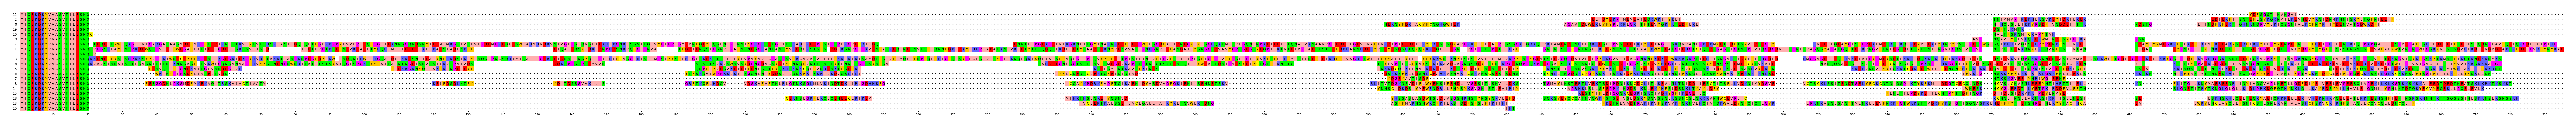

In [ ]:
# visualize the alignments
mv = MsaViz(alignment)
fig = mv.plotfig()

# Predicting Structure using ESMFold

We will use the [ESM Metagenomic Atlas, which provides an API](https://esmatlas.com/about#api) that folds a given protein amino acid sequence with ESMFold (esm.pretrained.esmfold_v1) and returns the predicted structure in PDB file format.

In [ ]:
headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
    }

# initiate list
pdb_files = []

for record in records:

    # get the sequence as a string
    sequence = str(record.seq)
    name = record.name

    # use API
    response = requests.post('https://api.esmatlas.com/foldSequence/v1/pdb/', headers=headers, data=sequence, verify=False)
    pdb_string = response.content.decode('utf-8')

    # verbose, response of 200 means success
    print(sequence, response)

    # adding time delay as to not overwhelm the server (increase this to encounter less 500 responses)
    time.sleep(1)

    # filename and path
    pdb_filename = f'{name}.pdb'
    pdb_path = os.path.join(output_path, pdb_filename)

    # save the pdb files
    with open(pdb_path, 'w') as f:
        f.write(pdb_string)

    # append filenames to list for later
    pdb_files.append(pdb_path)

MIQEKDKYVVASVTILESNQNEKNYFDKIACYFCNQHQWIEKAGAVTDLWEKLYFYPLRRLGKITFTEVYQKFRTEDFLKLNIHQLSLLIKKYPSDFIVNDDEIITTRNDSTGLIINDFRFERTIQHNRNQPVYLKIQSGNIVLKCFNYRIIYDENVATGDWKDFI <Response [200]>
MIQEKDKYVVASVTILESNQTV <Response [200]>
MIQEKDKYVVASVTILESNQELIDYEKPIMEMEVIEQRWKIIYKLITNIMMVPIREKHLRSVKEYIDKILKEKEDIEKFIISNTEFLSYKQRNMILKEMNEVYKNIDNMKNNISKYLTQFNIEEIF <Response [200]>
MIQEKDKYVVASVTILESNQKKENDCFYSLSHPKKSYYAGLKIWNECEYYFRGENLIKGEGKIEKGYHVRFTAKKTIANPKNPDGFDYLKWLNDQNIHWILHGQAIDLIKKESNIIEAIYNFRKDSIKLYLNQSIPNASQRIMIQALILGERSEIDNNLLNSYQILGIIHLFCVSGLHISLIMGSIYYSFLRIGLTKEKTTTLLLLYLVPVYVVIAGAQPSVFRAVVASVLLILFKKLKIKISAMDTFSIVFLMQLLFNPFQLFHIGFQLSYGLALSIVISYPLLKNQLQKIWQLIALSFFVQLGILPLQVYYFFEITPISILINIVFIPVFSIIIIPLSFIGFGLVFFPSLLPIIYAKFTFLLHFMLTILNEFIDIKHFFIVAGRPTWIIIFYYALIIYILLYFYKKWNIKNYISISFVVLLLLMIVKPYFNPYGEVTSIDVGQGDAIVLELPYRKGVVIIDAAGNKNFKEKDFWKKRSKPTIEHIISNGVRTIDYLFLTHGDLDHMGGVGELIEQFHVKEIAIPYGMEYNETLKKRIDQKKTKIHFIKKGDIIDISDSIDVKVLQPQKKGNNENDASIVMMAEIANHKWLFTGDLEGEGEKELLKRYGSIPIDFLKVGHHGSKTSNTEEF

In [ ]:
# visualize each pdb file retrieved from ESMfold using py3Dmol
for pdb_file in pdb_files:

    # get index
    seq_idx = int(re.findall(r'\d+', pdb_file)[-1])
    # get filename with no ext
    filename = re.findall(fr'{project_name}_\d+', pdb_file)
    print(f"Showing structure: {filename}")
    # retrieve sequences
    print(f"Sequence: {records[seq_idx].seq}")

    # generate viz
    view=py3Dmol.view()
    view.addModel(open(pdb_file, 'r').read(),'pdb')
    view.zoomTo()
    view.setBackgroundColor('white')
    #Here we set the visualization style for chain B and C
    view.setStyle({'cartoon': {'color':'yellow'}})
    view.show()

Showing structure: ['pML_course_0']
Sequence: MIQEKDKYVVASVTILESNQNEKNYFDKIACYFCNQHQWIEKAGAVTDLWEKLYFYPLRRLGKITFTEVYQKFRTEDFLKLNIHQLSLLIKKYPSDFIVNDDEIITTRNDSTGLIINDFRFERTIQHNRNQPVYLKIQSGNIVLKCFNYRIIYDENVATGDWKDFI


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_1']
Sequence: MIQEKDKYVVASVTILESNQTV


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_2']
Sequence: MIQEKDKYVVASVTILESNQELIDYEKPIMEMEVIEQRWKIIYKLITNIMMVPIREKHLRSVKEYIDKILKEKEDIEKFIISNTEFLSYKQRNMILKEMNEVYKNIDNMKNNISKYLTQFNIEEIF


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_3']
Sequence: MIQEKDKYVVASVTILESNQKKENDCFYSLSHPKKSYYAGLKIWNECEYYFRGENLIKGEGKIEKGYHVRFTAKKTIANPKNPDGFDYLKWLNDQNIHWILHGQAIDLIKKESNIIEAIYNFRKDSIKLYLNQSIPNASQRIMIQALILGERSEIDNNLLNSYQILGIIHLFCVSGLHISLIMGSIYYSFLRIGLTKEKTTTLLLLYLVPVYVVIAGAQPSVFRAVVASVLLILFKKLKIKISAMDTFSIVFLMQLLFNPFQLFHIGFQLSYGLALSIVISYPLLKNQLQKIWQLIALSFFVQLGILPLQVYYFFEITPISILINIVFIPVFSIIIIPLSFIGFGLVFFPSLLPIIYAKFTFLLHFMLTILNEFIDIKHFFIVAGRPTWIIIFYYALIIYILLYFYKKWNIKNYISISFVVLLLLMIVKPYFNPYGEVTSIDVGQGDAIVLELPYRKGVVIIDAAGNKNFKEKDFWKKRSKPTIEHIISNGVRTIDYLFLTHGDLDHMGGVGELIEQFHVKEIAIPYGMEYNETLKKRIDQKKTKIHFIKKGDIIDISDSIDVKVLQPQKKGNNENDASIVMMAEIANHKWLFTGDLEGEGEKELLKRYGSIPIDFLKVGHHGSKTSNTEEFIQKVVPKYSIISVGRNNSYGHPSSLVLARMKQLGTQVFITDKNGAIQYKFGSKYTKMNSFIKQTKNEKKNMKS


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_4']
Sequence: MIQEKDKYVVASVTILESNQKVAVSINNAISSTLSVSNITITNIKNNSASFTVKWLGQNSVNVAGFHVYYSTNDNPNWNRITATITSTSYAIQGLSPGKTYYFAITAINTNGDISNVSSIIKVTPVIVDSDDKTPPSTPTEMVVNSTSTTSVKVSWNVSYDPNGDVASYDIYCNNQFVNTTTNTTYTLNNLTGGTSYNFSVTAHDEEGNLSGTSSTLNVFTMEGDVKAPSTPTNLQTSNTENSQILIYWEASTDNIGVESYDIYCTGTFIKNTTQTTYLVPSLTAFTVYSFKIKAVDAAGNQSQEYITFNLKPGENQPPQKPTEPSAFSTRCSSSNIQLEWTESTDPLGGSVSYDVYREGKLVNTTTSTSYYENSPSLDMEFCYTVKAIDNANQQSADSSILSVTIGCEFCNLSSLSISPKNPIIHKGGTLIFTVDISSDADEVITLSISSSGSEEVSSANIAIKDNAISKTLTIYTPAEKAEGENIIIVSVQGNTSNTISLTLKVLSIEEEKEEKEVVEEVKEEREVEKEIPTWIIPIVAIGVAIIITIIYVVIKRSKKKAGGG


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_5']
Sequence: MIQEKDKYVVASVTILESNQFENVQSIFLGNDKVITGLVNNDEGIVHFIEKRGKNYQILAKFKLNPELEYFQNPFLYVDSVKEIEIFENLSTTFYQKHSKNKCQLFVNRENKTFSEFKLKSELSMLNTKAVSFKINESLNKKDCQIKILNVLKEKELLIKETPFLDIFFNENTELIDIYCKNSTIIGSNNVSSKRYYVKTFDKNIKTYELELKEEFRFLSVFQSSNKIIDFRSVDLNANHVYEKFNKKEHVNNVLYYLQKKTCDKFESWILICDNQNYRFSKLKKLDQVFDFDIISLQPKISIVPESFDKLSFISSEAKKINQSLQETINTKLKESLLDKEKLQKDLAERSKILSSKNLDILKLKFQNEKLIMDLREKVKENQLLKSKLKSMIWRIAKIRIFKKRNT


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_6']
Sequence: MIQEKDKYVVASVTILESNQWHINYPIPSDFLIATELTVDNYTFSKNVIWPPKKLKIISGQNLNIYDDSLILQNRFKISKHILKDVQSKIKIIYFLCNENTCLEKTQFEININIADDSKKSFRLLDSNKCEAHKVSNVKICSKVNSCSESISDNSTCNKLTNGDNKCYGYKNRIISKKIDFKKNKRNILINIHNIFRNQLLNSSNFWNVKINEKSKIKNKSDIFVKLGNSKKFFFLKKIKIKKGRKFNLILEKLSKKTKNNIKFYASIVTTNNENKHIISQTMGFYYEPIAVNLIFPTVCKNYDYCLEIFLPQECKKSSIKGKKCNKNSAFYSGIFIIILKYLLYFNKLLNN


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_7']
Sequence: MIQEKDKYVVASVTILESNQYDGEYAVTISDFNTKSKGVEEIYNRIWGIEENF


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_8']
Sequence: MIQEKDKYVVASVTILESNQFESGGDNLPKGMDFMKEKAQITRSKVIACTIVATVKEIFDSDKNTFYYDITDSSGVVKILISGRFTKQFLHDQVVDGKVFAFTNLRLGTNKSGKMLVKINDTDKIIRLGDHHKFGICQAYKPDRKFVPFTQIKAENIDYASDVVGFGKIENIISENNETSKVRKITVTDGKNSVDIFLWYENSIFENDLIVGESITLSNVILDKSTGMVYLNSTERTKVEKTSDIPDNIKNCDCKITLKEVLNKTNIDDIIESCTITSFLKVDKNIMYDGVEVCTSCKKSSITENDTGEKYFCKCNTNIQSPIKTYKFKMIIDDGTCECQLNDSNCVSLCNVSNKEEEYNTIHRTTIIEKLKNFKITGILKNYMAEREENRIINYIVQQVVPLNETLLGDFDIYEIVEELEVPEESQIAPEKIKKKKGTKKSKKKAIEEDTDEDTNEATSKKKRKTKSKKT


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_9']
Sequence: MIQEKDKYVVASVTILESNQAVGNQAVLYSLVKQKEKWMINDFSYIPLKAPSN


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_10']
Sequence: MIQEKDKYVVASVTILESNQIHT


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_11']
Sequence: MIQEKDKYVVASVTILESNQTVPGSRLAYLNSPRDDWQSGVIEIFWDGAFLITIEEIGDELISKTSVIISLDIIETLVPTKSEFNEVKEAELTYRQRIMIIIDEDEIKLLKAESIADLNKFFEIQAIEQSYIDRLDNPHDSNKVQFGLGNVATFDDIENQSIPSNVIPAFNTNDSGRANTANSYVRDQLKSTSFSDDLKSNVGLGKVENFATKDQINESNVTSFIQNNFDKLDKYIHHPIADATKNLVKLDTYTTSQDQTLRDLLDTYTAADTEKNYVDNVVASIPNHGNVIEFANDAILYSNGGSDVAVYGPTGDGTYEQPIIRTVTEIVPIAETTSTTEFDKHANNHDDRYVTEYESDSHTQYQYRKDQLLIEGNVGIGTTTPETILHAFGNLNLSSGCGNTNSLLKFEYNSNSGTTLAAFKWYSEATGIDHGTCIQSDTGAGTIGTNTPLVIQGDGDVLISGNLSVAGQSYAGATGQFTDLKVNGVFTNLDGTDLTTYTSNIINGVIGQSLVSGVGNTVTLTEAKQNYLKTQVNFSSVTANSIDATEYPNIGLITYINKDDTTFILTTSDVPGDCLDTTGVIYDGYYSYGFTISASTNSNSSCDVMFALYWTVNGNGWIGSKYVLSTSDVHIKDIEVDMDDAKSKFDDLPVRFYNYKAD


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_12']
Sequence: MIQEKDKYVVASVTILESNQYDFSGSTINVNGVI


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_13']
Sequence: MIQEKDKYVVASVTILESNQIVCLERTKALSSEILACLQALLIAIKYKLTNVWLKTDNGASFFMARNSNWKQFKILKSIQDFSFSLFIKIIHIFRETNLVADTPAKIKVFSKVVKFQKNVLHQIATQKWVLDYNFQIQTLGYRLPRNKVSNLSANYTMLNKLLEVFNRKFGTWRKSTTMDRFYKSIGTISQNASKKLHEFFFYTIETSNPEINLKYYTACIHCAEALWRYLNCLVYQLLFSNICSTLSNLKANIALVSHCFSKVCKIRNFSIANLLCQVCQLLDNCQLIF


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_14']
Sequence: MIQEKDKYVVASVTILESNQYNNSCIDKDSIYMEWRNDRLLFNYSYKGVGNISTLEAIRIYAPRHKLSLLSFEPPKINGDSIKNLEKYHFSLDSNKKTYAYLDFYLWNESKNCYGLERDTIKYETPKIRDDFVLFFTNSKGNETITRYTKNGKGLGLLKIDKPRKDQFQTHYNKKQILKAYRDSYYIKNVVLEIGNMIIYPNLNTDTQKYECVYEQEKLLPQELEVLK


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_15']
Sequence: MIQEKDKYVVASVTILESNQKESTYIFLDIGGNKCEGRISRQIVDHYGFIKEGEILQFLNLTILPDYKEIILCNTPYTTDFINGKDIIDLSIDKVKRIPDYLNMYE


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_16']
Sequence: MIQEKDKYVVASVTILESNQCNVLTFSRNMICKVPYTAH


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_17']
Sequence: MIQEKDKYVVASVTILESNQTEQELTYWLQKGILVIGARGATAASMDEFMRGFTEDIKNLTTRVIYTVTSHSKIASIIDQLQLTFGLKKPPYLVVLPIEQFGGIIEKNNSGQNDSNYIEEMIMKGTIVTLVLPDDMPKEQLESWIAHMHVDKVNIVGLPSIQVSLIEKHLKGNKLSSSITQIVYPIPPIGMEMNFQEYLQSLNIPINNIYGRGRTETGIITSRAHIKDEPFSIGSPLKGVECRIIDQDNNTLLPGEKGELVIRGKNLITGYINAKNKEEFLEEGWFLSGDFAIIDNEGYIYISGRQKTMITVLGQNINPKEIEEIITQNALVKNAAVVGLEDELLGEVIVAFIVKDIPIEEDEIIKYCRESLSDYAVPKRFIFLEAFPISSSGKIQRKQIVKIAMENDTNRLLQKRESLLPVSEEEIRIYKEIAGILSRQVVANLPKEKMYETIDFTSYVLDSEGLYRVEELLQEAYGISFPPEKLMDSRTLKQIKDYMLEKLYHNVYVSSIPESGWSISQIKRHIVQLSEHPYPENKCNLLVKELSDAYLYYMEGKKFTLKDFIKIMFKEEARYSERFIKKYILPYYENPDFNLICFREIGRILENRKIQLPKPQMILIESPMEGAFLSHLLDELEIFTELISLQDNPLAVFQEIQKGDLLLIPIHP


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_18']
Sequence: MIQEKDKYVVASVTILESNQCERNSLGRFLKQLQENEECLRIKEMMIHKTHSLNKEIYQSNVDYHSSASLASDWTSLDLVSGSNRNSTYNSYNKVLEFDSQKSYEYQCQATNVQWKFSTSEIVSLDSKYQNVSSNLRSSNCSLNKRKVNNWCEVPLICKCNNLINNLLAKNRSIRRIISLLNESISELSKHSKHLQELTEQKYAEIQRKRELLEKIVHEKNHKVQELEATLRKTESHSNFIENINSRSKHNNTKTTSQSSSINLSKRNSLKSNSSRH


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Showing structure: ['pML_course_19']
Sequence: MIQEKDKYVVASVTILESNQDSFTLRMTK


3Dmol.js failed to load for some reason. Please check your browser console for error messages.